Tensor Field Networks

Implementation of Newtonian gravity demonstration

In [3]:
%load_ext autoreload
%autoreload 2

In [76]:
%matplotlib inline

import random
from math import sqrt
import torch
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tensorfieldnetworks import utils, layers
from tensorfieldnetworks.utils import  FLOAT_TYPE
EPSILON = 1e-8
xrange = range

In [77]:
# radial basis functions
rbf_low = 0.
rbf_high = 2.
rbf_count = 30
rbf_spacing = (rbf_high - rbf_low) / rbf_count
centers = torch.Tensor(np.linspace(rbf_low, rbf_high, rbf_count))

In [78]:
def get_inputs(r):
    
    # rij : [N, N, 3]
    rij = utils.difference_matrix(r)

    # dij : [N, N]
    dij = utils.distance_matrix(r)

    # rbf : [N, N, rbf_count]
    gamma = 1. / rbf_spacing
    rbf = torch.exp(-gamma * (dij.unsqueeze(-1) - centers)**2)
    
    return rij, dij, rbf

In [86]:
model = layers.Filter(1,1, rbf_count, nonlin=utils.ssp)

In [87]:
import torch.optim as optim

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [88]:
def R_plot(layer, x):
    gamma = 1. / rbf_spacing
    rbf_plot = np.exp(-gamma * (x - centers)**2)
    return layer(torch.Tensor(rbf_plot))



In [89]:
def accelerations(points, masses=None):
    """
    inputs:
    -points: a list of 3-tuples of point coordinates
    -masses: a list (of equal length N) of masses
    
    returns: 
    -shape [N, 3] numpy array of accelerations under Newtonian gravity
    """
    accels = []
    if masses is None:
        masses = [1.0 for _ in range(len(points))]
    for i, ri_ in enumerate(points):
        accel_vec = np.array((0., 0., 0.))
        for j, rj_ in enumerate(points):
            rij_ = ri_ - rj_
            dij_ = np.linalg.norm(rij_)
            if (ri_ != rj_).any():
                accel_update = -rij_ / (np.power(dij_, 3) + EPSILON) * masses[j]
                accel_vec += accel_update
        accels.append(accel_vec)
    assert len(accels) == len(points)
    return np.array(accels)


def random_points_and_masses(max_points=10, min_mass=0.5, max_mass=2.0, 
                             max_coord=rbf_high, min_separation=0.5):
    """
    returns:
    -shape [N, 3] numpy array of points, where N is between 2 and max_points
    -shape [N] numpy array of masses
    """
    num_points = random.randint(2, max_points)
    candidate_points = []
    for point in xrange(num_points):
        candidate_points.append(
            np.array([random.uniform(-max_coord, max_coord) for _ in range(3)]))
    
    # remove points that are closer than min_separation
    output_points = []
    for point in candidate_points:
        include_point = True
        for previous_point in output_points:
            if np.linalg.norm(point - previous_point) < min_separation:
                include_point = False
        if include_point:
            output_points.append(point)
    
    points_ = np.array(output_points)
    masses_ = np.random.rand(len(output_points)) * (max_mass - min_mass) + min_mass
    return points_, masses_

In [90]:
max_steps = 1001
validation_size = 1000
print_freq = 1000

F1_y_vals = []
x_vals = [index * rbf_high / rbf_count for index in range(rbf_count + 1)]

# training
min_separation = 0.5
for step in range(max_steps):
    if step%100 == 0 :
        print(step)
    rand_points, rand_masses = random_points_and_masses(max_points=10, 
                                                        min_separation=min_separation)
    rand_masses_m = np.reshape(rand_masses, [len(rand_masses), 1, 1])
    
    accel = np.expand_dims(accelerations(rand_points, rand_masses), axis=-2)
    
    masses = torch.Tensor(rand_masses_m)
    rij, dij, rbf = get_inputs(torch.Tensor(rand_points))
    optimizer.zero_grad()
    outputs = model(masses, rbf, rij)

    loss = criterion(outputs, torch.Tensor(accel))

    loss.backward()
    optimizer.step()


    # print performance on different random point set every print_freq steps
    if step % print_freq == 0:
        loss_sum = 0.
        for _ in xrange(validation_size):
            validation_points, validation_masses = random_points_and_masses(max_points=50,
                                                                            min_separation=min_separation)
            validation_masses_m = np.reshape(validation_masses, [len(validation_masses), 1, 1])
                
            validation_accel = np.expand_dims(accelerations(validation_points, validation_masses), axis=-2)
    
            validation_masses = torch.Tensor(validation_masses_m)
            val_rij, val_dij, val_rbf = get_inputs(torch.Tensor(validation_points))
            outputs = model(validation_masses, val_rbf, val_rij)

            validation_loss = criterion(outputs, torch.Tensor(validation_accel))
            loss_sum += validation_loss
        print("Step %d: validation loss = %.3f" % (step, loss_sum / validation_size))

        # for plotting radial function
        r_layer = model.children().__next__().children().__next__()
        y_vals = []
        for x_val in x_vals:
            y_vals.append(R_plot(r_layer,  x_val))
        F1_y_vals.append((step, y_vals))

0
Step 0: validation loss = 5.150
100
200
300
400
500
600
700
800
900
1000
Step 1000: validation loss = 0.032


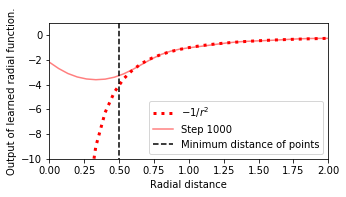

In [91]:
# plot radial function and compare with -1/r^2

radial_fig = plt.figure(figsize=(5,2.5))
ax = radial_fig.add_subplot(1,1,1)

min_index_cutoff = int((1 / sqrt(40.) - rbf_low) / rbf_spacing)
ax.plot(x_vals[min_index_cutoff:], [-1 / r_**2 for r_ in x_vals[min_index_cutoff:]], "r:", lw=3, label="$-1/r^2$")

for step, y_vals in F1_y_vals[1:]:
    line, = ax.plot(x_vals, y_vals, 'r', alpha=0.5, label="Step {}".format(step))
    line.set_ydata(y_vals)

ax.plot([min_separation, min_separation], [10,-50], 'k--', label="Minimum distance of points")
ax.set_ylabel("Output of learned radial function.")
ax.set_xlabel("Radial distance")
ax.set_xlim(0., 2.0)
ax.set_ylim(-10, 1.)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
radial_fig.canvas.draw()